# Heteroskedastic Multitask Multi-Output Regression

## Introduction

This notebook demonstrates how to perform multitask regression across multiple multi-output models, while using a heteroskedastic noise model fit on observed measurement noise. 

In many practial applications, 


In [1]:
import math
import torch
import time

import gpytorch

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from gpytorch.likelihoods import (
    _GaussianLikelihoodBase,
    GaussianLikelihood,
    _MultitaskGaussianLikelihoodBase,
    MultitaskGaussianLikelihood,
    MultitaskGaussianLikelihoodKronecker,
    HeteroskedasticNoise,
)


class HadamardMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks, rank):
        super(HadamardMultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        shape = train_x.shape if torch.is_tensor(train_x) else train_x[0].shape
        ard_num_dims = None if len(shape) < 2 else shape[-1]
        self.covar_module = gpytorch.kernels.RBFKernel(ard_num_dims=ard_num_dims)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank=rank)

    def forward(self, x, i):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_i = self.task_covar_module(i)
        covar = covar_x.mul(covar_i)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

We have multiple "task" tasks - i.e. offline vs. online batches, or multiple online batches. For each "task" task we have multiple outcomes.

Let's start with the simplest case of 2 "task" tasks and 2 outcomes

In [3]:
cuda = True
dtype = torch.float

device = torch.device("cuda") if cuda else torch.device("cpu")

In [4]:
# first "task" task

train_x11 = torch.linspace(0, 1, 75, dtype=dtype, device=device)
train_x12 = torch.linspace(0, 1, 50, dtype=dtype, device=device)

min_sem1 = 0.1
max_sem1 = 0.65

sem_y11 = min_sem1 + (max_sem1 - min_sem1) * train_x11
sem_y12 = max_sem1 - (max_sem1 - min_sem1) * train_x12

train_y11 = torch.sin(train_x11 * (2 * math.pi)) + sem_y11 * torch.randn_like(train_x11)
train_y12 = torch.cos(train_x12 * (2 * math.pi)) + sem_y12 * torch.randn_like(train_x12)

train_y11_log_var = 2 * sem_y11.log() 
train_y12_log_var = 2 * sem_y12.log() 

In [5]:
# second "task" task - just a slightly shifted version of the previous task
train_x21 = train_x11 + 0.05 * (torch.rand_like(train_x11) - 0.5)
train_x22 = train_x12 + 0.05 * (torch.rand_like(train_x12) - 0.5)

min_sem2 = 0.1
max_sem2 = 0.65

sem_y21 = max_sem2 - (max_sem2 - min_sem2) * train_x21
sem_y22 = min_sem2 + (max_sem2 - min_sem2) * train_x22

train_y21 = torch.sin((train_x21 - 0.1) * (2 * math.pi)) + sem_y21 * torch.randn_like(train_x21)
train_y22 = torch.cos((train_x22 - 0.1) * (2 * math.pi)) + sem_y22 * torch.randn_like(train_x22)

train_y21_log_var = 2 * sem_y21.log() 
train_y22_log_var = 2 * sem_y22.log() 

In [6]:
# indices
train_i11 = torch.full_like(train_y11, dtype=torch.long, device=train_y11.device, fill_value=0)
train_i12 = torch.full_like(train_y12, dtype=torch.long, device=train_y12.device, fill_value=1)
train_i21 = torch.full_like(train_y21, dtype=torch.long, device=train_y21.device, fill_value=2)
train_i22 = torch.full_like(train_y22, dtype=torch.long, device=train_y22.device, fill_value=3)

In [7]:
# full model input
train_x = torch.cat([train_x11, train_x12, train_x21, train_x22])
train_y = torch.cat([train_y11, train_y12, train_y21, train_y22])
train_i = torch.cat([train_i11, train_i12, train_i21, train_i22])

## Basic Model inferring a homoskedastic noise

Note that with the Hadamard model there is currently no way to learn differnt noise levels for the separate tasks

In [8]:
likelihood = GaussianLikelihood()
model = HadamardMultitaskGPModel((train_x, train_i), train_y, likelihood, num_tasks=4, rank=4)

if dtype == torch.double:
    likelihood.double()
    model.double()

if cuda:
    model = model.cuda()

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
tic = time.time()
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x, train_i)
    loss = -mll(output, train_y, [train_x, train_i])
    loss.backward()
    if (i+1) % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

print(f"wall time: {time.time() - tic:.2f}")

Iter 10/100 - Loss: 0.691
Iter 20/100 - Loss: 0.547
Iter 30/100 - Loss: 0.542
Iter 40/100 - Loss: 0.558
Iter 50/100 - Loss: 0.523
Iter 60/100 - Loss: 0.545
Iter 70/100 - Loss: 0.521
Iter 80/100 - Loss: 0.559
Iter 90/100 - Loss: 0.569
Iter 100/100 - Loss: 0.574
wall time: 3.88


In [10]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 45, dtype=dtype, device=device)

test_i = {
    i: torch.full_like(test_x, dtype=torch.long, device=device, fill_value=i)
    for i in range(4)
}
post_f, post_obs = {}, {}


with torch.no_grad(), gpytorch.fast_pred_var():
    for i, ti in test_i.items():
        post_f[i] = model(test_x, ti)
        post_obs[i] = likelihood(post_f[i], [test_x, ti])

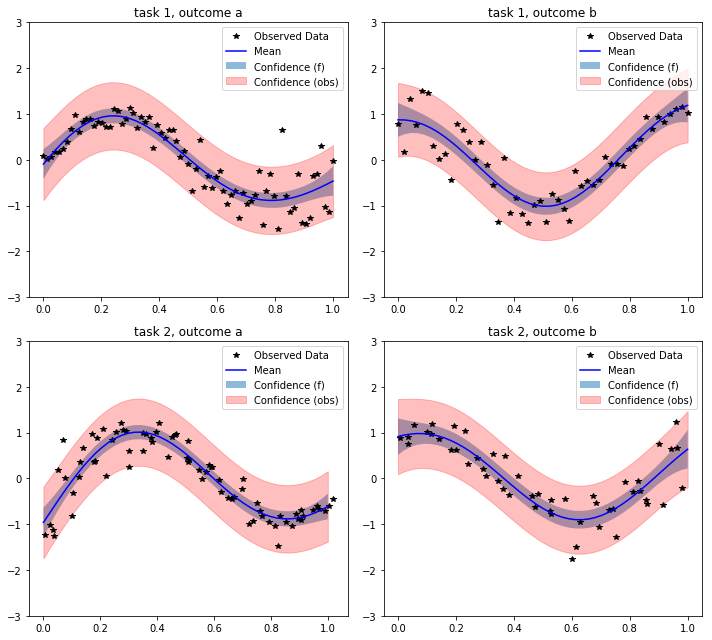

In [11]:
# some helpers to make plotting easier
train_x_dict = {
    0: train_x11, 1: train_x12, 2: train_x21, 3: train_x22, 
}
train_y_dict = {
    0: train_y11, 1: train_y12, 2: train_y21, 3: train_y22, 
}
labels = {
    0: "task 1, outcome a",
    1: "task 1, outcome b",
    2: "task 2, outcome a",
    3: "task 2, outcome b",
}

f, axs = plt.subplots(2, 2, figsize=(10, 9))
for i in range(4):
    ax = axs[i//2, i - (i//2) * 2]
    lower_f, upper_f = post_f[i].confidence_region()
    lower_obs, upper_obs = post_obs[i].confidence_region()
    ax.plot(train_x_dict[i].cpu().numpy(), train_y_dict[i].cpu().numpy(), 'k*')
    ax.plot(test_x.cpu().numpy(), post_f[i].mean.cpu().numpy(), 'b')
    ax.fill_between(test_x.cpu().numpy(), lower_f.cpu().numpy(), upper_f.cpu().numpy(), alpha=0.5)
    ax.fill_between(test_x.cpu().numpy(), lower_obs.cpu().numpy(), upper_obs.cpu().numpy(), alpha=0.25, color='r')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence (f)', 'Confidence (obs)'])
    ax.set_title(labels[i])
    
plt.tight_layout()

## Use a multi-task GP trained on noise observations as a heteroskedastic noise model

In [12]:
train_x_log_var = train_x
train_i_log_var = train_i
train_y_log_var = torch.cat([
    train_y11_log_var,
    train_y12_log_var,
    train_y21_log_var,
    train_y22_log_var,
])

In [13]:
noise_likelihood = GaussianLikelihood()
noise_model = HadamardMultitaskGPModel(
    (train_x_log_var, train_i_log_var), train_y_log_var, noise_likelihood, num_tasks=4, rank=4,
)

In [14]:
likelihood = _GaussianLikelihoodBase(
    noise_covar=HeteroskedasticNoise(noise_model),
)
model = HadamardMultitaskGPModel((train_x, train_i), train_y, likelihood, num_tasks=4, rank=4)

if dtype == torch.double:
    likelihood.double()
    model.double()

if cuda:
    model = model.cuda()

**Note: To be able to train this we need to turn off the check for whether the model trains on the training data.**

In [15]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Disabling this check is necessary when using the Heteroskedastic likelihood
with gpytorch.settings.check_training_data(False):
    tic = time.time()
    n_iter = 100
    for i in range(n_iter):
        optimizer.zero_grad()
        output = model(train_x, train_i)
        loss = -mll(output, train_y, [train_x, train_i])
        loss.backward()
        if (i+1) % 10 == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
        optimizer.step()
    print(f"wall time: {time.time() - tic:.2f}")

Iter 10/100 - Loss: 0.955
Iter 20/100 - Loss: 0.745
Iter 30/100 - Loss: 0.624
Iter 40/100 - Loss: 0.525
Iter 50/100 - Loss: 0.531
Iter 60/100 - Loss: 0.526
Iter 70/100 - Loss: 0.504
Iter 80/100 - Loss: 0.518
Iter 90/100 - Loss: 0.517
Iter 100/100 - Loss: 0.541
wall time: 4.04


In [16]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 45, dtype=dtype, device=device)

test_i = {
    i: torch.full_like(test_x, dtype=torch.long, device=device, fill_value=i)
    for i in range(4)
}
post_f, post_obs = {}, {}


with torch.no_grad(), gpytorch.fast_pred_var():
    for i, ti in test_i.items():
        post_f[i] = model(test_x, ti)
        post_obs[i] = likelihood(post_f[i], [test_x, ti])

/home/bgavin/anaconda3/envs/sar/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:177: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


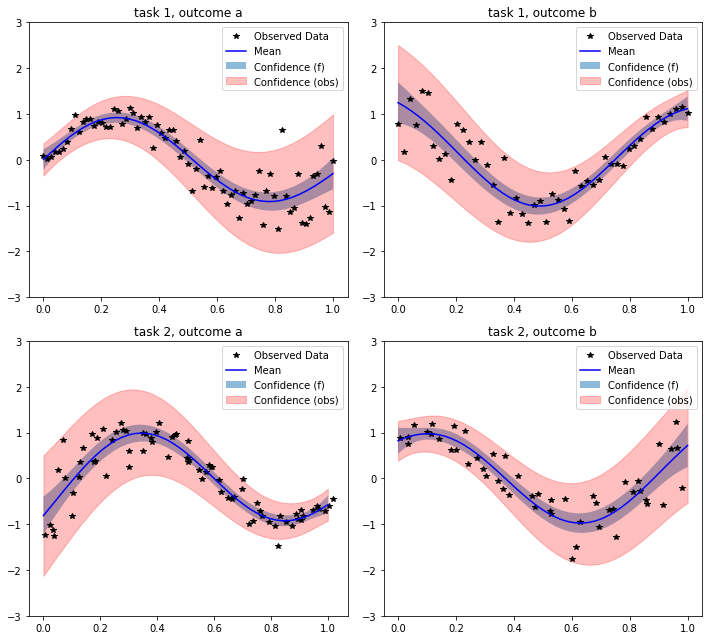

In [17]:
# some helpers to make plotting easier
train_x_dict = {
    0: train_x11, 1: train_x12, 2: train_x21, 3: train_x22, 
}
train_y_dict = {
    0: train_y11, 1: train_y12, 2: train_y21, 3: train_y22, 
}
labels = {
    0: "task 1, outcome a",
    1: "task 1, outcome b",
    2: "task 2, outcome a",
    3: "task 2, outcome b",
}

f, axs = plt.subplots(2, 2, figsize=(10, 9))
for i in range(4):
    ax = axs[i//2, i - (i//2) * 2]
    lower_f, upper_f = post_f[i].confidence_region()
    lower_obs, upper_obs = post_obs[i].confidence_region()
    ax.plot(train_x_dict[i].cpu().numpy(), train_y_dict[i].cpu().numpy(), 'k*')
    ax.plot(test_x.cpu().numpy(), post_f[i].mean.cpu().numpy(), 'b')
    ax.fill_between(test_x.cpu().numpy(), lower_f.cpu().numpy(), upper_f.cpu().numpy(), alpha=0.5)
    ax.fill_between(test_x.cpu().numpy(), lower_obs.cpu().numpy(), upper_obs.cpu().numpy(), alpha=0.25, color='r')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence (f)', 'Confidence (obs)'])
    ax.set_title(labels[i])
    
plt.tight_layout()